# Fabio Tatti s282383

Collaborated with: ("Andrea Silvi", "s290312"), ("Andrea Rizzardi", "s287396"), ("Maria Francesca Turco", "s278427")

# Exercise 1 

## Question A
We first build the transition rate matrix $\Lambda$

In [31]:
import numpy as np

nodes = ["o", "a","b", "c","d"]
Lambda =np.array( [[0 , 2/5, 1/5, 0,0],\
                    [0, 0, 3/4, 1/4, 0],\
                    [0.5, 0, 0, 0.5, 0],\
                    [0, 0, 1/3, 0 , 2/3],\
                    [0, 1/3, 0, 1/3, 0]])
w = np.sum(Lambda, axis = 1)
w_star = np.max(w)
P = np.linalg.inv(np.eye(5)*w) @ Lambda

In [2]:
class poisson_Clock():
    # class to emulate the Poisson Clock behaviour
    def __init__(self, rate):
        self.rate = rate
    def tick(self):
        return -np.log(np.random.rand())/self.rate
clock = poisson_Clock(0.5)
print(f"Example of poisson clock tick:{clock.tick()}")

Example of poisson clock tick:3.6455202364344195


In [3]:
def hit_ret(P, origin, dest):
    #function to simulate the hitting time if origin != dest or the returning time if 
    #origin == dest
    dizionario = {"o":0,"a":1,"b":2,"c":3,"d":4}
    tot_time = 0
    final_state = dizionario[dest]
    init_state = dizionario[origin]
    prob_distr = P[init_state]
    clock = poisson_Clock(w[init_state])
    tot_time += clock.tick()
    tot_steps = 1
    
    while True:
        #select a random state from 0 to 4 (np.arange(5)) with given probabilities p
        next_state = np.random.choice(5,1, p = prob_distr)[0]
        if next_state == final_state:
            break
        prob_distr = P[next_state]
        #declare new clock for the new step node
        clock = poisson_Clock(w[next_state])
        tot_time += clock.tick()
        tot_steps += 1
        
    return tot_time, tot_steps

#Now we compute multiple iterations of the return time of node a

origin = dest = "a"
iterations = 100000
time_tot = steps_tot = 0
for i in range(iterations):
    time, steps = hit_ret(P, origin, dest)
    time_tot += time
    steps_tot += steps
print(f"Average return time for node a is: {time_tot/iterations}")
print(f"Average steps to return for node {origin} is: {int(steps_tot/iterations)}")


Average return time for node a is: 6.748841867970345
Average steps to return for node a is: 5


## Question B
We compute the theoretical value by exploiting theory's equations

In [4]:
P_bar = (Lambda + np.diag(np.ones(len(w))*w_star-w))/w_star 


eigVals, eigVect = np.linalg.eig(P_bar.T)

#the function returns eigvals with complex part, but we only need the real one
index = np.argmax(eigVals.real)
pi_bar = eigVect[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)

name_to_state = {'o':0,'a':1, 'b':2, 'c':3, 'd':4}
theoretical_returnTime = 1/(w[name_to_state['a']]*pi_bar[name_to_state['a']])
print(f"The theoretical return time is {theoretical_returnTime}")

The theoretical return time is 6.750000000000008


## Question C
Compute hitting time from node o to node d

In [5]:
#we now compute the average hitting time from node o to node d

origin = "o"
dest = "d"
iterations = 100000
time_tot = steps_tot = 0
for i in range(iterations):
    time, steps = hit_ret(P, origin, dest)
    time_tot += time
    steps_tot += steps
print(f"Average hitting time from node {origin} to node {dest} is: {time_tot/iterations}")
print(f"Average steps taken is: {int(steps_tot/iterations)}")

Average hitting time from node o to node d is: 8.789368224874442
Average steps taken is: 7


## Question D
Compute the theoretical hitting time from node o to node d, by solving a system $Ax = b$

In [6]:
A = np.eye(4)-P[:-1,:-1]
b = np.ones(4)/w[:-1]
theor_time = np.linalg.solve(A,b)[0]
#we take the first entry since we are starting from o
print(f"The theoretical time is: {theor_time}")
P[:-1,:-1]
P_z = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
P_z[:-1,:-1]

The theoretical time is: 8.785714285714285


array([[1, 2, 3],
       [5, 6, 7]])

## Question E
We build the $G$ graph by using the $\Lambda$ matrix as weight matrix to simuate the French-DeGroot model. 

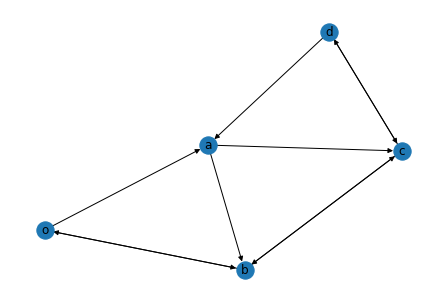

In [7]:
import networkx as nx

#we build the graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in range(len(Lambda)):
    a = Lambda[i]
    
    for j in range(len(a)):
        da = a[j]
        if da != 0:
            G.add_edge(nodes[i], nodes[j])
            G[nodes[i]][nodes[j]]["capacity"] = da
pos = nx.drawing.layout.spring_layout(G)
nx.draw(G,pos,with_labels=True)

In [8]:
# we generate the random vector for the initial condition 
init_dist = np.random.rand(5)
# since is a distribution we normalize it
x = init_dist/np.sum(init_dist)

iterations = 1000
#to simulate we iterate by multiplying for the P 
for i in range(iterations):
    x = np.dot(P,x)
print(x)

[0.18109165 0.18109165 0.18109165 0.18109165 0.18109165]


As we can see from the results the graph $G$ will converge to the consensus, since strongly connected and aperiodic.

## Question F
Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are i.i.d random variables with variance σ2. Compute the variance of the consensus value, and compare your results with numerical simulations.

In [9]:
#wisdom of crowds lab 5, we can see from previous point that 
#the graph is strongly connected and aperiodic
iterations = 10000
alfa_err = np.zeros(iterations)
# start with random initial states and run the dynamics
#std = sigma**2
sigma_squared = 0.5
std = np.sqrt(sigma_squared)
mu = 1/2
for i in range(iterations):
    x = np.random.normal(mu, std,len(nodes))
    for n in range(500):
        x = P @ x
    alfa_err[i] = (mu - np.mean(x))*(mu - np.mean(x))

print(f"Variance of the node states: {sigma_squared}" )
print("Variance of the consensus state:", np.mean(alfa_err), "\n")

Variance of the node states: 0.5
Variance of the consensus state: 0.10613013846125816 



In [10]:
#we now solve the system to get the theoretical value

eigVals, eigVect = np.linalg.eig(P.T)
#since we only want the real part of the biggest eigenvalue we get its index
index = np.argmax(eigVals.real)
pi = eigVect[:,index].real
pi = pi/np.sum(pi)

theoretical_crowd_var = sigma_squared * pi@pi
theoretical_crowd_var

0.10680529300567107

## Question G

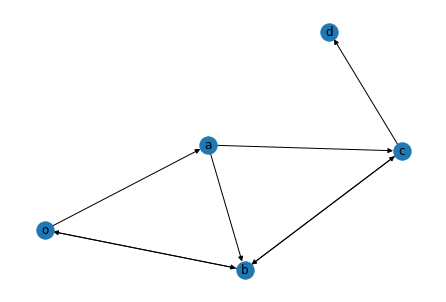

In [11]:
new_Lambda = Lambda.copy()
new_Lambda[4, 1] = 0 #remove (d,a) edge
new_Lambda[4,3] = 0  #remove (d,c) edge

#we build the graph
G_new = nx.DiGraph()
G_new.add_nodes_from(nodes)
for i in range(len(new_Lambda)):
    a = new_Lambda[i]
    
    for j in range(len(a)):
        da = a[j]
        if da != 0:
            G_new.add_edge(nodes[i], nodes[j])
            G_new[nodes[i]][nodes[j]]["capacity"] = da
nx.draw(G_new,pos,with_labels=True)

In [12]:
new_Lambda[4,4] = 1
new_w = np.sum(new_Lambda, axis = 1)
new_P = np.linalg.inv(np.eye(5)*new_w) @ new_Lambda
# we generate the random vector for the initial condition 
init_dist = np.random.rand(5)
# since is a distribution we normalize it


x = init_dist/np.sum(init_dist)

print(f"The initial value of node d is {x[-1]}")
iterations = 1000
#to simulate we iterate by multiplying for the new_P 
for i in range(iterations):
    x = new_P@x
print(f"The dynamics with {iterations} iterations is {x}")


The initial value of node d is 0.18477962263929076
The dynamics with 1000 iterations is [0.18477962 0.18477962 0.18477962 0.18477962 0.18477962]


As we can see the dynamics converges to the consensus where all the nodes have the same value that was initially assigned to the node d. In fact, as we can see from the printed graph this coincide with the fact that node's d opinion affects b, and so all the rest of the network, but d doesn't change its opinion. That means that we can model d like it has a self loop, since it maintain its opinion unchanged, leading the rest of the network to the convergence.

In [13]:
#wisdom of crowds lab 5, we can see from previous point that 
#the graph is strongly connected and aperiodic
iterations = 10000
alfa_err = np.zeros(iterations)
# start with random initial states and run the dynamics
#std = sigma**2
sigma_squared = 0.5
std = np.sqrt(sigma_squared)
mu = 1/2
for i in range(iterations):
    x = np.random.normal(mu, std,len(nodes))
    for n in range(500):
        x = new_P @ x
    alfa_err[i] = (mu - np.mean(x))*(mu - np.mean(x))

print(f"Variance of the node states: {sigma_squared}" )
print("Variance of the consensus state:", np.mean(alfa_err), "\n")

Variance of the node states: 0.5
Variance of the consensus state: 0.5012463141369075 



In [14]:
#we now solve the system to get the theoretical value

eigVals, eigVect = np.linalg.eig(new_P.T)
#since we only want the real part of the biggest eigenvalue we get its index
index = np.argmax(eigVals.real)
pi = eigVect[:,index].real
pi = pi/np.sum(pi)

theoretical_crowd_var = sigma_squared * pi@pi
theoretical_crowd_var

0.5

## Question H


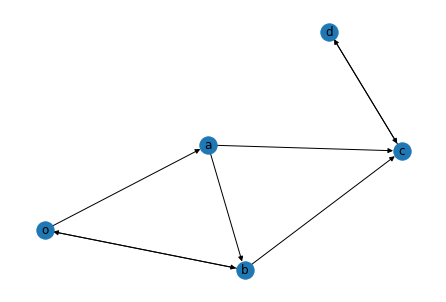

In [15]:
new_Lambda = Lambda.copy()
new_Lambda[3, 2] = 0 #remove (c,b) edge
new_Lambda[4,1] = 0  #remove (d,a) edge
#we build the graph
G_new2 = nx.DiGraph()
G_new2.add_nodes_from(nodes)
for i in range(len(new_Lambda)):
    a = new_Lambda[i]
    
    for j in range(len(a)):
        da = a[j]
        if da != 0:
            G_new2.add_edge(nodes[i], nodes[j])
            G_new2[nodes[i]][nodes[j]]["capacity"] = da
nx.draw(G_new2,pos,with_labels=True)


In [16]:
new_w = np.sum(new_Lambda, axis = 1)
new_P = np.linalg.inv(np.eye(5)*new_w) @ new_Lambda

# we generate the random vector for the initial condition 
init_dist = np.random.rand(5)
# since is a distribution we normalize it


x = init_dist/np.sum(init_dist)
c = x[-2]
d = x[-1]
print(f"The initial distribution is {x}")
iterations = 100000
#to simulate we iterate by multiplying for the new_P 
for i in range(iterations):
    x = new_P@x
print(f"The dynamics with {iterations} iterations is {x}")
print(f"Mean of c - d initial values: {(c + d)/2}")

The initial distribution is [0.1432975  0.30517017 0.4597248  0.0058156  0.08599193]
The dynamics with 100000 iterations is [0.04282006 0.03973635 0.0674897  0.0058156  0.08599193]
Mean of c - d initial values: 0.045903764382910835


In that case c-d create a connected component where they swap constantly their opinion among them: moreover c opinion will affect the restof the network that will have overall a value that is near to the middle between c and d initial values. This beacause in alternate times the opinion coming from the connected component c-d will oscillate between those two values. 

# Problem 2
## Question A 
We first build the simulation from a particle perspective, returning time for node a given 100 particles

In [17]:


#Now we compute multiple iterations of the return time of node a
#this has to be done for each particle in the system
num_particles = 100
origin = dest = "a"
iterations = 1000
times = step = 0
for i in range(iterations):
    time_tot = steps_tot = 0
    for particle in range(num_particles):
        time, steps = hit_ret(P, origin, dest)
        time_tot += time
        steps_tot += steps
    times += time_tot/num_particles
    step += steps_tot/num_particles
print(f"Average return time for node a is: {times/iterations}")
print(f"Average steps to return for node a is: {int(step/iterations)}")


Average return time for node a is: 6.755492965858614
Average steps to return for node a is: 5


As we can see the average returning time for 100 particles in node a is equal to the one for just one particle. This because the behaviour of each particle in equal to the behaviour of the others, so, in the end, iterate 1000 times over 100 particle can be seen as iterating 100000 over one particle. Since we were computing already a big number of iterations given a small and simple graph we did already reached a stable value for the returning time, meaning that it won't change when we increase the number of particles/iterations. As we can see also the number of steps is the same.

## Question B
Now we compute the simulation from the node perspective with a global Poisson clock with rate 100. All the particles will start in node o and we will simulate the system for 60 time units.


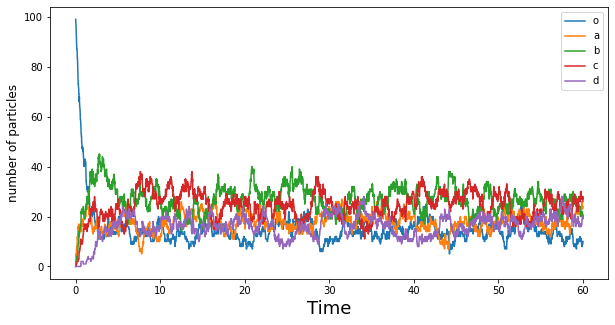

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def nodes_perspective(P,num_particles, origin, end_time):
    #initial setup
    nodes = {"o":0,"a":1, "b":2,"c":3, "d":4}
    particle_nodes = np.zeros(5)
    particle_nodes[nodes[origin]] = num_particles
    #we create a poisson clock with rate = num_particles
    rate = num_particles
    clock = poisson_Clock(rate)
    timer = 0
    counter = 0
    data = []
    while True:
        time = clock.tick()
        timer += time
        if timer >end_time:
            break
        #create the proportion according to the distributions, has to be a distribution
        dist = particle_nodes/np.sum(particle_nodes)
        #choose a node proportionally to the number of particles
        chosen_node = np.random.choice(5,1, p = dist)[0]
        prob_distr = P[chosen_node]
        next_node = np.random.choice(5,1,p = prob_distr)[0]
        particle_nodes[chosen_node] += -1
        particle_nodes[next_node] += +1
        to_append = [timer, particle_nodes[0], particle_nodes[1], particle_nodes[2], particle_nodes[3],particle_nodes[4]]
        data.append(to_append)
    #return the total time and the average time
    return data

end_time = 60
data_to_plot = nodes_perspective(P,num_particles, "o" , end_time)
data = pd.DataFrame(data_to_plot)
fig ,ax = plt.subplots()
data.plot(x = 0, figsize = (10, 5), ax = ax)
plt.xlabel('Time', fontsize=18)
plt.ylabel('number of particles', fontsize=12)
ax.legend(nodes)


In [35]:
#we want to compute the average number of particles in the last step of the simulation 
#given many iterations
results_simulations = []

for i in range(int(iterations)):
    data = nodes_perspective(P_bar,num_particles, "o" , end_time)
    if i == 500:
        print("Half of the work done!")
    #we now select the last row in order to take the last step of the simulation
    last = data[-1]
    results_simulations.append(last[1:])
results = pd.DataFrame(results_simulations)
results.columns = nodes
#mean value over the columns to get the mean over each node
print(f"The resulting average numbers of particles in the last step of the simulation for each node are \n{results.mean(axis = 0).astype(int)}")

The resulting average numbers of particles in the last step of the simulation for each node are 
o    18
a    15
b    22
c    22
d    22
dtype: int64


In [41]:
#now we compare with the pi_bar from the first exercise
print(f"The stationary distribution of the of the continuos time random walk is {pi_bar}")
res = (results.sum(axis = 0).astype(int)/iterations)/np.sum(results.sum(axis = 0).astype(int)/iterations)
print(f"The simulation result is \n{res}")

The stationary distribution of the of the continuos time random walk is [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
The simulation result is 
o    0.1815
a    0.1502
b    0.2240
c    0.2214
d    0.2229
dtype: float64


# Problem 3


In [21]:
Lambda_2 = [[0, 2/3, 1/3, 0,0],\
        [0, 0, 0.25, 0.25, 0.5],\
        [0, 0, 0, 1, 0],\
        [0, 0, 0, 0, 1],\
        [0, 0, 0, 0, 1]]
w_2 = np.sum(Lambda_2, axis = 1)
P_2 = np.linalg.inv(np.eye(5)*w_2) @ Lambda_2

Graph with proportional rate for Poisson clocks of the nodes, in rate 100


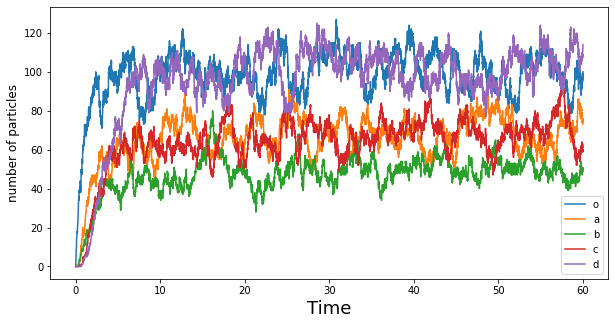

In [22]:
def prop_fixed_rate(P, in_rate, time_simulation, fixed = False):
    #fixed parameter is used to set the nodes' clocks behaviour: proportional ratio for False, fixed to 1 if True
    clock_in = poisson_Clock(in_rate)
    particles_nodes = np.zeros(5)
    data = []
    to_append = [0, particles_nodes[0], particles_nodes[1], particles_nodes[2], particles_nodes[3],particles_nodes[4]]
    data.append(to_append)
    #we set already the first time that is the tick of the in click for the first particle
    particles_nodes[0] += 1
    timer = clock_in.tick()
    #we save the first configuration of the network
    to_append = [timer, particles_nodes[0], particles_nodes[1], particles_nodes[2], particles_nodes[3],particles_nodes[4]]
    data.append(to_append)
    while True:
        #we store the clicks of all clocks present in the network
        results_clocks = []
        #in_time will be the time of the in clock 
        in_time = clock_in.tick()
        for i in range(5):
            if particles_nodes[i] == 0:
                #append big value in order to not be taken as minimum
                results_clocks.append(50)
            else:
                #here we make the clock for the given node that has at least one particle
                if fixed == False:
                    node_rate = particles_nodes[i]
                else: 
                    node_rate = 1
                clock = poisson_Clock(node_rate)
                results_clocks.append(clock.tick())
        #now we take the minimum value of the clocks of the nodes to compare it with in one
        min_time_nodes = np.min(results_clocks)
        
        #the minimum between in_time and min_time_nodes will activate two different actions
        #before we check to not exceed from the maximum time of the simulation
        timer += np.min([min_time_nodes, in_time])
        if timer > time_simulation:
            break
        #if we can continue we activate two branches
        if min_time_nodes >in_time:
            #the in rated clocks ticks before, we only have to add a particle in o
            particles_nodes[0] += 1
        else:
            #since the nodes ticks before the in clock we now choose the ticking clock
            chosen_node = np.argmin(results_clocks)
            if chosen_node == 4:
                #it is the node d that only loses particles when it ticks with prob = 1
                particles_nodes[-1] += -1
            else:
                #the next node is chosen according to the transition probability distribution of the chosen node
                prob_dist = P[chosen_node]
                next_node = np.random.choice(5, 1, p = prob_dist)[0]
                particles_nodes[chosen_node] += -1
                particles_nodes[next_node] += +1
                
        #we append the new state to the list of lists data
        to_append = [timer, particles_nodes[0], particles_nodes[1], particles_nodes[2], particles_nodes[3],particles_nodes[4]]
        data.append(to_append)
    return data
end_time = 60
in_rate = 100
data_to_plot = prop_fixed_rate(P_2,in_rate, end_time)
data = pd.DataFrame(data_to_plot)
fig ,ax = plt.subplots()
data.plot(x = 0, figsize = (10, 5), ax = ax)
plt.xlabel('Time', fontsize=18)
plt.ylabel('number of particles', fontsize=12)
ax.legend(nodes)
print(f"Graph with proportional rate for Poisson clocks of the nodes, in rate {in_rate}" )


## Question B
Now we fix the rate of the Poisson clock of each node, that has now rate 1

Graph with fixed rate for Poisson clocks of the nodes, in rate 5


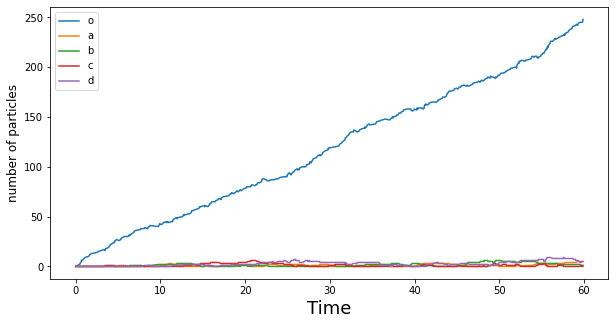

In [23]:

end_time = 60
in_rate = 5
data_to_plot = prop_fixed_rate(P_2,in_rate, end_time, True)
data = pd.DataFrame(data_to_plot)
fig ,ax = plt.subplots()
data.plot(x = 0, figsize = (10, 5), ax = ax)
plt.xlabel('Time', fontsize=18)
plt.ylabel('number of particles', fontsize=12)
ax.legend(nodes)
print(f"Graph with fixed rate for Poisson clocks of the nodes, in rate {in_rate}" )
